# Создание датасета


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pickle

with open('/content/drive/MyDrive/hack/metrikc_data_for_definition_main.pkl', 'rb') as f:
    metrikc_data_for_definition_main = pickle.load(f)

with open('/content/drive/MyDrive/hack/train_data_for_definition_main.pkl', 'rb') as f:
    train_data_for_definition_main = pickle.load(f)

# Список с датасетом

In [5]:
metrikc_data_for_definition_main[0]

0

In [6]:
metrikc_data_for_definition_main.count(0)

3417

In [7]:
train_data_for_definition_main[0]

' Друзья, привет!'

# Обработка датасетов


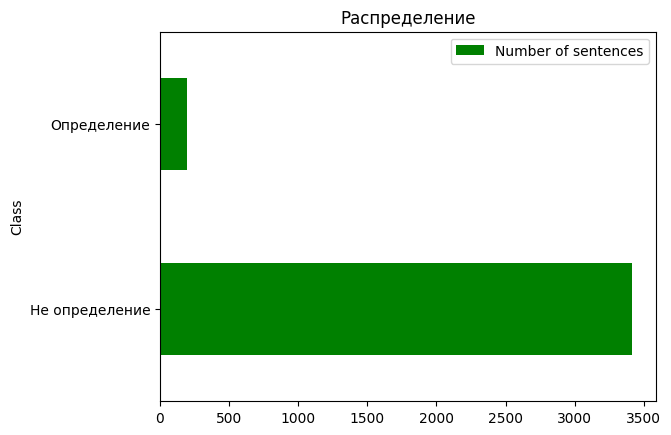

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'Class': ['Не определение', 'Определение'],
                   'Number of sentences':[metrikc_data_for_definition_main.count(0),metrikc_data_for_definition_main.count(1)]})
df.plot.barh(x='Class', y='Number of sentences',
             title='Распределение', color='green')
plt.show()

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(metrikc_data_for_definition_main, num_classes=2)
x_train, x_test, y_train, y_test = train_test_split(train_data_for_definition_main,metrikc_data_for_definition_main,test_size=0.15,shuffle = True)

In [19]:
# Check the lengths
len(train_data_for_definition_main),len(metrikc_data_for_definition_main),len(x_train), len(x_test), len(y_train), len(y_test)

(3611, 3611, 3069, 542, 3069, 542)

In [20]:
# View the first 10 training titles and their labels
x_train[:10], y_train[:10]

(['По идее, у нас должно вывесться hello, потом 123, и то, что мы введем с командной строки.',
  'Эти значения могут быть целочисленными, строковыми, а также хранить в себе и более сложные объекты.',
  'И в заключение давайте еще расскажу про Python-консоль в IDE-PHR.',
  'Где третий?',
  ' Итак, друзья, мы настроили окружение, вспомнили базовые термины.',
  ' Друзья, перед тем, как порешать конкретные задачки на обработку массивов, давайте обсудим еще такой вопрос, как применимость знаний о массивах, ну и в целом навыков программирования на конкретных специальностях.',
  'Итак, наш с вами блок-хеддер.',
  'Друзья, как вы думаете, какой тип алгоритма здесь нам поможет?',
  'Мы не обнулили отступы в принципе.',
  'Но вот это вот дублирование или это называется вложенностью, это плохо.'],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
%pip install datasets

In [21]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, f1_score

In [13]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [14]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-sentence', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
seq_len_train = [len(str(i).split()) for i in x_train]
seq_len_test = [len(str(i).split()) for i in x_test]
max_seq_len = max(max(seq_len_test), max(seq_len_train))
max_seq_len

82

In [16]:
tokens_train = tokenizer.batch_encode_plus(
    x_train,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    x_test,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Data(tokens_train, y_train)
test_dataset = Data(tokens_test, y_test)

In [26]:
from sklearn.metrics import f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    s=0
    for i in range(len(preds)):
        if(labels[i]==1 and preds[i]==1):
            s+=10
        elif(labels[i]==0 and preds[i]==0):
            s+=5
        elif(labels[i]==0 and preds[i]==1):
            s+=1
        else: s+=0
    return {'Our metrics': (s/10)/len(preds)}

In [18]:
!pip install -U accelerate
!pip install -U transformers

In [19]:
#import os
#os._exit(00)

In [36]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 1, #Кол-во эпох для обучения
    per_device_train_batch_size = 20, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 20, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [37]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Our metrics
1,0.000800,0.000024,0.525741


TrainOutput(global_step=154, training_loss=0.0008151630883093005, metrics={'train_runtime': 83.9075, 'train_samples_per_second': 36.576, 'train_steps_per_second': 1.835, 'total_flos': 129324222597240.0, 'train_loss': 0.0008151630883093005, 'epoch': 1.0})

In [39]:
model_path = "fine-tune-bert-for-oprs"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('fine-tune-bert-for-oprs/tokenizer_config.json',
 'fine-tune-bert-for-oprs/special_tokens_map.json',
 'fine-tune-bert-for-oprs/vocab.txt',
 'fine-tune-bert-for-oprs/added_tokens.json')

In [40]:
def get_prediction():
    test_pred = trainer.predict(test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
pred = get_prediction()

In [41]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
print(classification_report(y_test, pred))
# print(f1_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       506
           1       0.96      0.72      0.83        36

    accuracy                           0.98       542
   macro avg       0.97      0.86      0.91       542
weighted avg       0.98      0.98      0.98       542



In [43]:
import shutil
shutil.make_archive(model_path, 'zip', model_path)

'/content/fine-tune-bert-for-oprs.zip'

# Использование модели


In [25]:
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
#import os
#os._exit(00)

In [1]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, f1_score

In [2]:
class Data(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
            item["labels"] = torch.tensor([self.labels[idx]])
            return item
        def __len__(self):
            return len(self.labels)

def get_prediction(trainer,test_dataset):
        test_pred = trainer.predict(test_dataset)
        labels = np.argmax(test_pred.predictions, axis = -1)
        return labels

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    s=0
    for i in range(len(preds)):
        if(labels[i]==1 and preds[i]==1):
            s+=10
        elif(labels[i]==0 and preds[i]==0):
            s+=5
        elif(labels[i]==0 and preds[i]==1):
            s+=1
        else: s+=0
    return {'Our metrics': (s/10)/len(preds)}

def get_ans_from_opr_model(list_of_test_texts):
    model_path = "/content/drive/MyDrive/hack/opr_model"
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    training_args = TrainingArguments(output_dir = './results', #Выходной каталог
                                    num_train_epochs = 1, #Кол-во эпох для обучения
                                    per_device_train_batch_size = 20, #Размер пакета для каждого устройства во время обучения
                                    per_device_eval_batch_size = 20, #Размер пакета для каждого устройства во время валидации
                                    weight_decay =0.01, #Понижение весов
                                    logging_dir = './logs', #Каталог для хранения журналов
                                    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
                                    learning_rate = 1e-5, #Скорость обучения
                                    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
                                    logging_strategy = 'epoch', #Логирование после каждой эпохи
                                    save_strategy = 'epoch', #Сохранение после каждой эпохи
                                    save_total_limit = 1,
                                    seed=21)

    tester = Trainer(model=model,
                    tokenizer = tokenizer,
                    args = training_args)

    max_seq_len=100
    tokens_test = tokenizer.batch_encode_plus(
        list_of_test_texts,
        max_length = max_seq_len,
        padding = 'max_length',
        truncation = True
    )

    test_dataset = Data(tokens_test, [1]*len(list_of_test_texts))

    return get_prediction(tester, test_dataset)

def get_oprs_from_list(list_of_sentances):
  pred = get_ans_from_opr_model(list_of_sentances)
  out=[]
  for i in range(len(pred)):
    if pred[i]: out.append(list_of_sentances[i])
  return out

In [16]:
get_oprs_from_list(x_test)

['Сетевые технологии - это технологии, которые позволяют создавать и использовать компьютерные сети для обмена информацией между различными устройствами',
 ' Определение CSS при процессоре — это программный подход к CSS.',
 ' Мы в переменную var3 записываем значение того, что нам вернёт функция input, а она нам вернёт то, что пользователь ведёт с командной строки.',
 'Классический маркетинг можно разделить на шесть важных этапов.',
 'Дистанционное зондирование Земли - это методы и технологии получения изображений поверхности Земли с помощью спутниковых систем или других средств',
 'Киберпреступность - это преступления, связанные с использованием компьютерных технологий для нарушения прав собственности, личной информации и других прав человека',
 'Сумерки — время между заходом и восходом солнца, когда небо постепенно переходит от дневного света к ночному',
 'Эманация — процесс исхождения какого-либо свойства или качества из чего-либо другого',
 'Демократия - это политический режим, в ко